In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [11]:
import torch
import torchvision
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
from torch import nn
from torchinfo import summary
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((32, 32), interpolation=v2.InterpolationMode.NEAREST),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

trainset = torchvision.datasets.MNIST(root="data", download=True, train=True, transform=transform)

In [5]:
image, label = trainset[44]

In [6]:
image.shape

torch.Size([1, 32, 32])

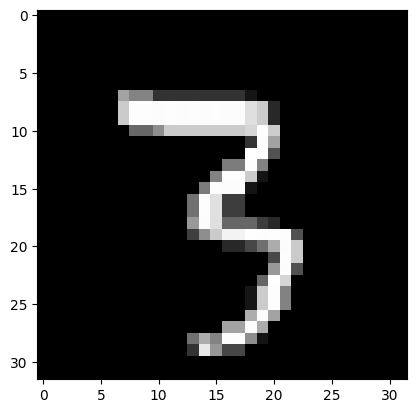

In [7]:
plt.imshow(image[0], cmap='grey')
plt.show()

## Model

In [8]:
%load_ext autoreload
%autoreload 2

In [33]:
from unet import UNet
import torch.nn.functional as F
import numpy as np
import torchode as to

In [47]:
class FlowMatching(nn.Module):
    def __init__(self, c_unet=16, sigma=1e-5):
        super().__init__()

        self.sigma = sigma
        self.model = UNet(
            time_embedding_dim=5,
            in_channels=1,
            out_channels=1,
        )
    
    def forward(self, batch):
        # latent: [B, C, H, W]
        latent, labels = batch

        noise = torch.randn_like(latent)
        time = torch.rand(latent.shape[0], device=latent.device)
        t = time.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        # eq 22 and 23 in the paper
        x_t = (1 - (1 - self.sigma) * t) * noise + t * latent
        target = latent - (1 - self.sigma) * noise

        v = self.model(x_t, t)
        loss = F.mse_loss(v, target)

        return loss
    
    def generate(self, batch_size, h=32, w=32, n_steps=10, device="cuda"):
        noise = torch.randn(batch_size, self.model.in_channels, h, w, device=device)
        t = torch.linspace(0, 1, n_steps, device=device)
        t = t.unsqueeze(0).repeat(batch_size, 1)

        def fn(t, x):
            x = x.view(*noise.shape)
            t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            out = self.model(x, t)
            return out.view(batch_size, -1)


        # ODE Solver
        y0 = noise.view(batch_size, -1)
        term = to.ODETerm(fn)
        step_method = to.Dopri5(term=term)
        step_size_controller = to.IntegralController(
            atol=1e-6, rtol=1e-3, term=term
        )
        solver = to.AutoDiffAdjoint(step_method, step_size_controller)
        output = solver.solve(to.InitialValueProblem(y0=y0, t_eval=t))
        output = output.ys[:, -1].view(*noise.shape)

        return output

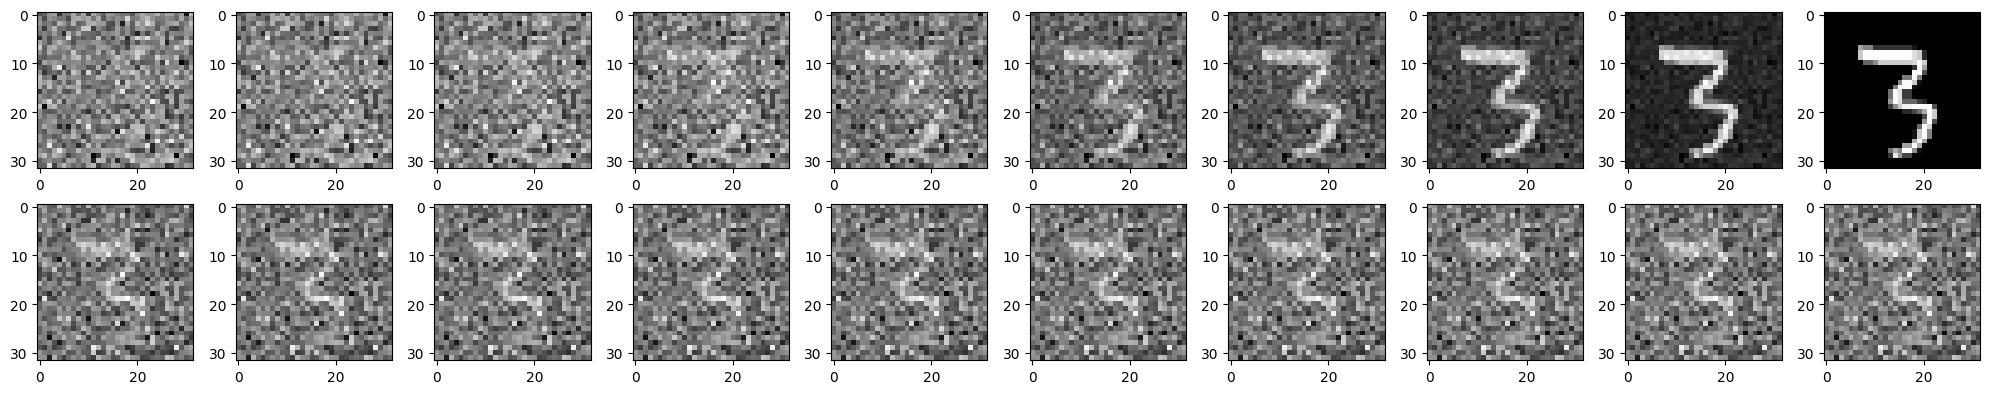

In [48]:
latent = image
noise = torch.randn_like(latent)

n_steps = 10
fig, axes = plt.subplots(2, n_steps, figsize=(n_steps * 2, 4))

sigma = 1e-5
for i, time in enumerate(np.linspace(0, 1, n_steps)):
    t = torch.tensor(time).unsqueeze(0).unsqueeze(0).unsqueeze(0)

    x_t = (1 - (1 - sigma) * t) * noise + t * latent
    target = latent - (1 - sigma) * noise

    axes[0, i].imshow(x_t[0], cmap='grey')
    axes[1, i].imshow(target[0], cmap='grey')

plt.tight_layout()
plt.show()

In [49]:
fm = FlowMatching()
fm = fm.to(device)

In [50]:
def display_generations(model, epoch, exp_name, n_samples=5):
    generated = model.generate(n_samples, device=device)

    fig, axes = plt.subplots(1, n_samples, figsize=(10, n_samples * 2))
    axs = axes.flatten()

    for i in range(n_samples):
        axs[i].imshow(generated[i].detach().cpu().numpy()[0], cmap="grey")

    plt.tight_layout()
    plt.savefig(f"logging/{exp_name}/epoch_{epoch}.png")

In [ ]:
num_epochs = 120 
batch_size = 512 
lr = 3e-4 # Karpathy constant

train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

fm = FlowMatching().to(device)
optim = torch.optim.Adam(fm.parameters(), lr=lr)

In [52]:
from tqdm.notebook import tqdm

In [ ]:
from datetime import datetime
import os
timestamp = datetime.now().strftime("%Y-%m-%d-%H%M")
exp_name = "new-unet"
os.makedirs(f"logging/{exp_name}", exist_ok=True)


for epoch in range(num_epochs):
    fm.eval()
    display_generations(fm, epoch, exp_name=exp_name)

    fm.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (x, y) in loop:
        x = x.to(device)
        y = y.to(device)
        loss = fm((x, y))

        optim.zero_grad()
        loss.backward()
        optim.step()

        loop.set_postfix(loss=loss.item())
    loop.close()

fm.eval()
display_generations(fm, epoch, exp_name=timestamp)
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 39.50 GiB of which 1.81 MiB is free. Process 604579 has 2.61 GiB memory in use. Including non-PyTorch memory, this process has 36.87 GiB memory in use. Of the allocated memory 36.22 GiB is allocated by PyTorch, and 146.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 